In [1]:
# System and other standard libraries
import os
import pickle
import random
import time
import re
import itertools
import json
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
from huggingface_hub import login

# Data processing, metrics and plot libraries
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

from sklearn.preprocessing import MinMaxScaler
# Pytorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.multiprocessing as mp
from torchinfo import summary

# Custom packages 
from utils import utils_forc,utils_forc_fm
import importlib
importlib.reload(utils_forc)
importlib.reload(utils_forc_fm)
from utils.utils_forc import *
from utils.forecasting_models import* 
from utils.utils_forc_fm import *

# Enabling polars global string cache, for more informaiton read below:
# https://docs.pola.rs/api/python/stable/reference/api/polars.StringCache.html
pl.enable_string_cache()

In [2]:
def set_seed(seed):
    random.seed(seed)  # Set seed for Python's random module
    np.random.seed(seed)  # Set seed for NumPy
    
    # Setting seed for PyTorch devices
    torch.manual_seed(seed)  # For CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # For current GPU (if using CUDA)
set_seed(42)

In [3]:
# Setting device type to be trained as "cuda" if aviablable else "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#load a small subset of data from PotSim
df_forc= pd.read_excel(Path("data") / "forecasting_data_subset.xlsx")


In [5]:
#Printig unique scenarios
get_unique_scenarios(df_forc)


Treatment: ['0-0-0' '0-0-112' '0-0-168' '0-0-196' '0-0-56' '0-112-0' '0-112-112'
 '0-112-168' '0-112-196' '0-112-56']
PlantingDay: [29 43]
NFirstApp: ['Npl']
IrrgDep: [30]
IrrgThresh: [70]
Year: [2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]


(119, 20)


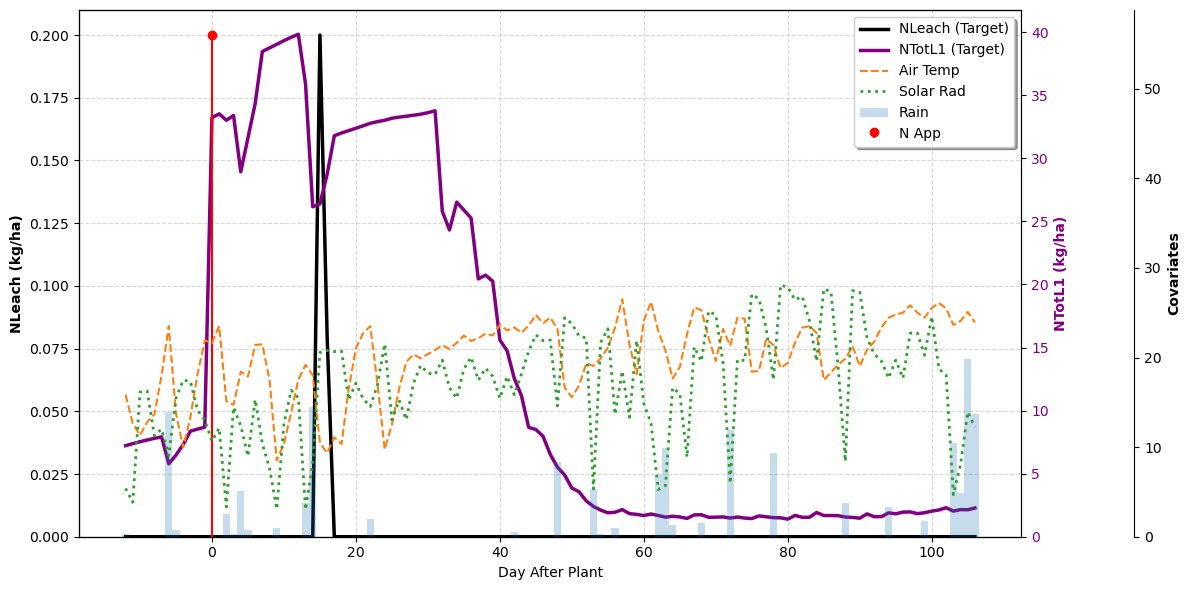

In [6]:
# Create a random scenario and visualise the crop cycles wrt their covarites 
sc=get_one_scenario(df_forc,year=2020,planting_day=43,treatment='56-0-0')
print(sc.shape)
visualize_interaction(sc)

In [7]:
df_forc.columns

Index(['Unnamed: 0', 'Year', 'Date', 'Treatment', 'NFirstApp', 'PlantingDay',
       'IrrgDep', 'IrrgThresh', 'DayAfterPlant', 'NApp', 'NLeach', 'NPlantUp',
       'NTotL1', 'NTotL2', 'Irrg', 'SWatL1', 'SWatL2', 'Rain', 'SolarRad',
       'AirTempC'],
      dtype='object')


### Prepare data



#### If training : run the cell below!

In [8]:
# df_model,X_train_s, X_test_s,y_train_s, y_test_s,x_scaler, y_scaler,scen_train_aligned, scen_test_aligned=prepare_timeseries_tensors(df_forc)
#df_model_ntotl1,X_train_s_ntotl1, X_test_s_ntotl1,y_train_s_ntotl1, y_test_s_ntotl1,x_scaler_ntotl1, y_scaler_ntotl1,scen_train_aligned_ntotl1, scen_test_aligned_ntotl1=prepare_timeseries_tensors(df_forc,target='NTotL1')

In [9]:
# df_model.shape, X_train_s.shape,y_train_s.shape,X_test_s.shape,y_test_s.shape

#### For Inference

In [10]:
# For "Nitrogen Leaching"
df_l, X_l, y_l, x_scaler_l, y_scaler_l, scen_meta_l = prepare_timeseries_tensors_inference(
    df_forc=df_forc,
    covariates=("NApp", "Rain", "SolarRad", "AirTempC"),
    target="NLeach",
    time_col="DayAfterPlant",
    scenario_cols=("Year", "Treatment", "NFirstApp", "PlantingDay", "IrrgDep", "IrrgThresh"),
    seq_len=119,
    drop_incomplete=True,
)
print("Shape of the tensors for Leaching and Soil Nitrogen",X_l.shape, y_l.shape)
# For "Nitrogen Uptake"
df_ntotl1, X_ntotl1, y_ntotl1, x_scaler_ntotl1, y_scaler_ntotl1, scen_meta_ntotl1 = prepare_timeseries_tensors_inference(
    df_forc=df_forc,
    covariates=("NApp", "Rain", "SolarRad", "AirTempC"),
    target="NTotL1",
    time_col="DayAfterPlant",
    scenario_cols=("Year", "Treatment", "NFirstApp", "PlantingDay", "IrrgDep", "IrrgThresh"),
    seq_len=119,
    drop_incomplete=True,
)


Shape of the tensors for Leaching and Soil Nitrogen (1860, 119, 4) (1860, 119)


### Loading Trained Forecasting Models

In [11]:
#Rolling approach: Forecasting


In [12]:
#Trained models are saved in the following paths
model_pth={'nleach_w30': r"saves\NLeach\forecasting\rolling_transformer_1step_ckpt.pth",
                'nleach_w60': r"saves\NLeach\forecasting\rolling_transformer_nleach_w60_1step_ckpt.pth",
                'soiln_w30':r"saves\NTotL1\rolling_transformer_ntotl1_w30_1step_ckpt.pth",
                'soiln_w60':r"saves\NTotL1\rolling_transformer_ntotl2_w60_1step_ckpt.pth" }

In [13]:
#Loading the trained Forecasters
model_roll_nleach_w30=get_loaded_forc_mdl(model_pth['nleach_w30'])
model_roll_nleach_w60=get_loaded_forc_mdl(model_pth['nleach_w60'])
model_roll_ntotl1_w30=get_loaded_forc_mdl(model_pth['soiln_w30'])
model_roll_ntotl1_w60=get_loaded_forc_mdl(model_pth['soiln_w60'])

#### Plotting trained models with changing context windiws and horizon(chunk size)

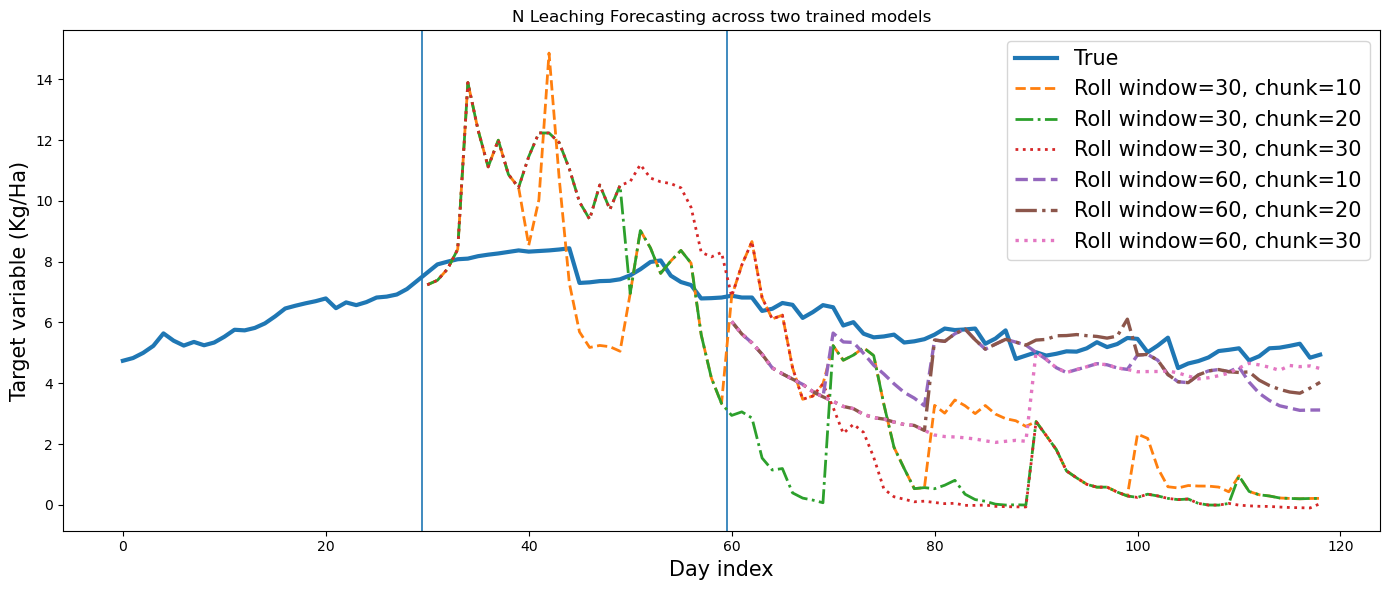

In [14]:
# Soil N- "NTotL1" Varaible.
#Change the value of "idx" to plot different time series/ management scenario; idx goes from 0 to 1860
plot_two_windows_varying_chunks_with_true_context(
    idx=1,
    model_roll_w30=model_roll_ntotl1_w30,
    model_roll_w60=model_roll_ntotl1_w60,
    X_test_s=X_ntotl1,
    y_test_s=y_ntotl1,
    y_scaler=y_scaler_ntotl1,
    chunks=(10, 20, 30),
    title="N Leaching Forecasting across two trained models" 
)


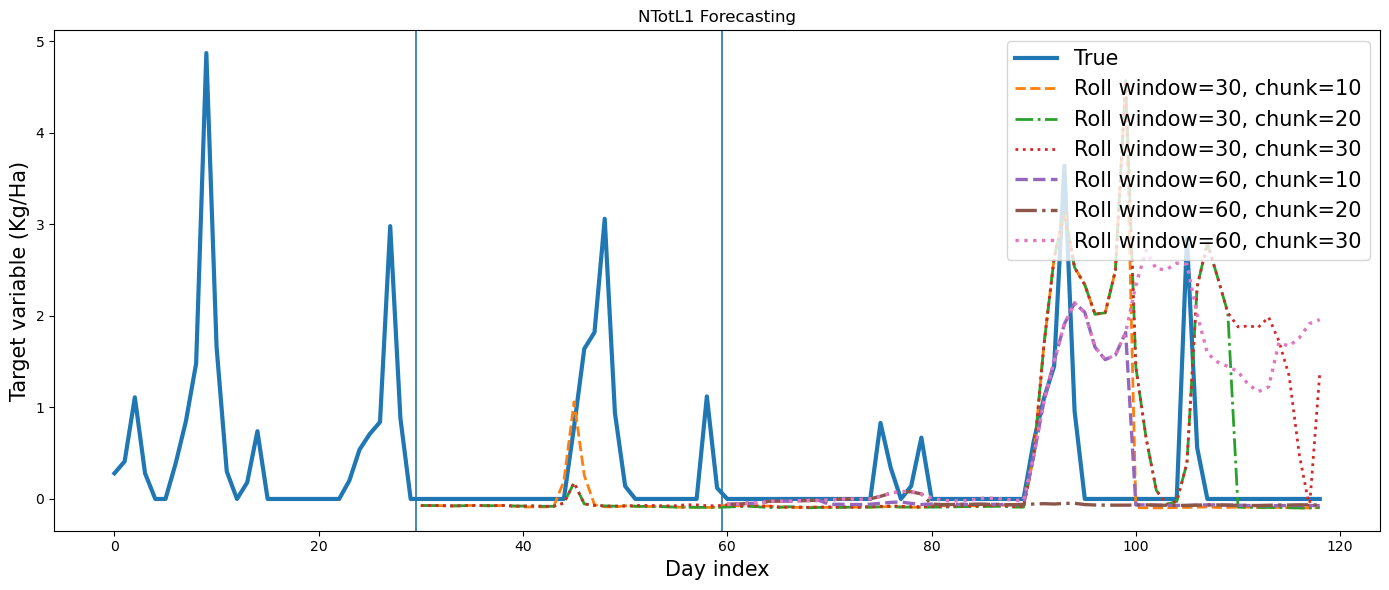

In [15]:
# N Leaching - "NLeach" Varaible
#Change the value of "idx" to plot different time series/ management scenario.

plot_two_windows_varying_chunks_with_true_context(
    idx=1,
    model_roll_w30=model_roll_nleach_w30    ,
    model_roll_w60=model_roll_nleach_w60,
    X_test_s=X_l,
    y_test_s=y_l,
    y_scaler=y_scaler_l,
    chunks=(10, 20, 30),
    title="NTotL1 Forecasting" 
)


### Loading Foundational Models

In [16]:
MODELS = {
    "chronos_t5_large_v1": {"id": "amazon/chronos-t5-large", "type": "chronos"},
    "chronos_t5_base_v1": {"id": "amazon/chronos-t5-base", "type": "chronos"},
    "chronos_v2":         {"id": "amazon/chronos-2",       "type": "chronos"},

    "moirai_large_v1":    {"id": "Salesforce/moirai-1.0-R-large", "type": "moirai"},
    "moirai_base_v1":     {"id": "Salesforce/moirai-1.0-R-base",  "type": "moirai"},
    "moirai_small_v2":    {"id": "Salesforce/moirai-2.0-R-small", "type": "moirai"},
}

loaded_models= load_models_any(MODELS)

Loaded chronos_t5_large_v1 -> amazon/chronos-t5-large
Loaded chronos_t5_base_v1 -> amazon/chronos-t5-base
Loaded chronos_v2 -> amazon/chronos-2
Loaded moirai_large_v1 -> Salesforce/moirai-1.0-R-large
Loaded moirai_base_v1 -> Salesforce/moirai-1.0-R-base
Loaded moirai_small_v2 -> Salesforce/moirai-2.0-R-small


##### Nitrogen Leaching ('N Leach') variable Forecsting : Trained models and Foundational Models 

In [17]:
#Getting results for all foundational models: for some time series range given in 'idxs' 
foundation_results = forecast_all_foundation_models_from_start_new(
    loaded_models,
    X_l,
    y_l,
    idxs=np.arange(5,10),             # include idx you want
    context_length=30,
    min_horizon=20,
    y_scaler=y_scaler_l,
    x_scaler=x_scaler_l,
    num_samples=200,
)


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


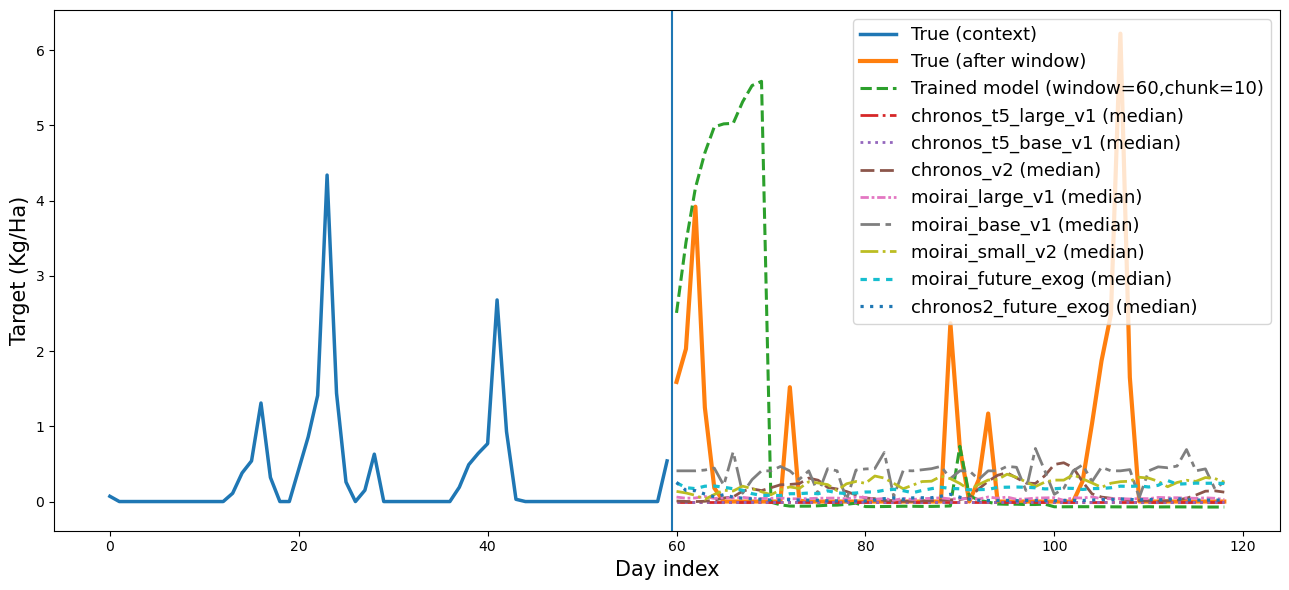

In [18]:
# Nitrogen Leaching Forecsting results :: Trained models and Foundational Models 
#This definiton uses the 'idx' to select the time series to be forecasted. , takes results from previous defintion: this is purely a plotting defition.
#Change value of idx within 'idxs' range- to get newer Crop management scenario/Time series. 
# #if you change the trained model from 'model_roll_nleach_w30' to 'model_roll_nleach_w60', please change the window also from 30 to 60 to see best results.
plot_idx_context_and_forecast(
    idx=8,
    model_roll=model_roll_nleach_w60,
    X_test_s=X_l,
    y_test_s=y_l,
    y_scaler=y_scaler_l,
    foundation_results=foundation_results,
    window=60,
    chunk=10,

    moirai_module_for_oracle=loaded_models["moirai_small_v2"],
    chronos2_pipeline_for_oracle=loaded_models["chronos_v2"],
    x_scaler=x_scaler_l,
    covariate_names=["NApp", "Rain", "SolarRad", "AirTempC"],
)


##### Soil Nitrogen ('NTotL1') variable Forecsting : Trained models and Foundational Models 

In [19]:
#Getting results for all foundational models: for some time series range given in 'idxs' 
foundation_results_ntot = forecast_all_foundation_models_from_start_new(
    loaded_models,
    X_ntotl1,
    y_ntotl1,
    idxs=np.arange(5,10),             # include idx you want
    context_length=30,
    min_horizon=10,
    y_scaler=y_scaler_ntotl1,
    x_scaler=x_scaler_ntotl1,
    num_samples=200,
)


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


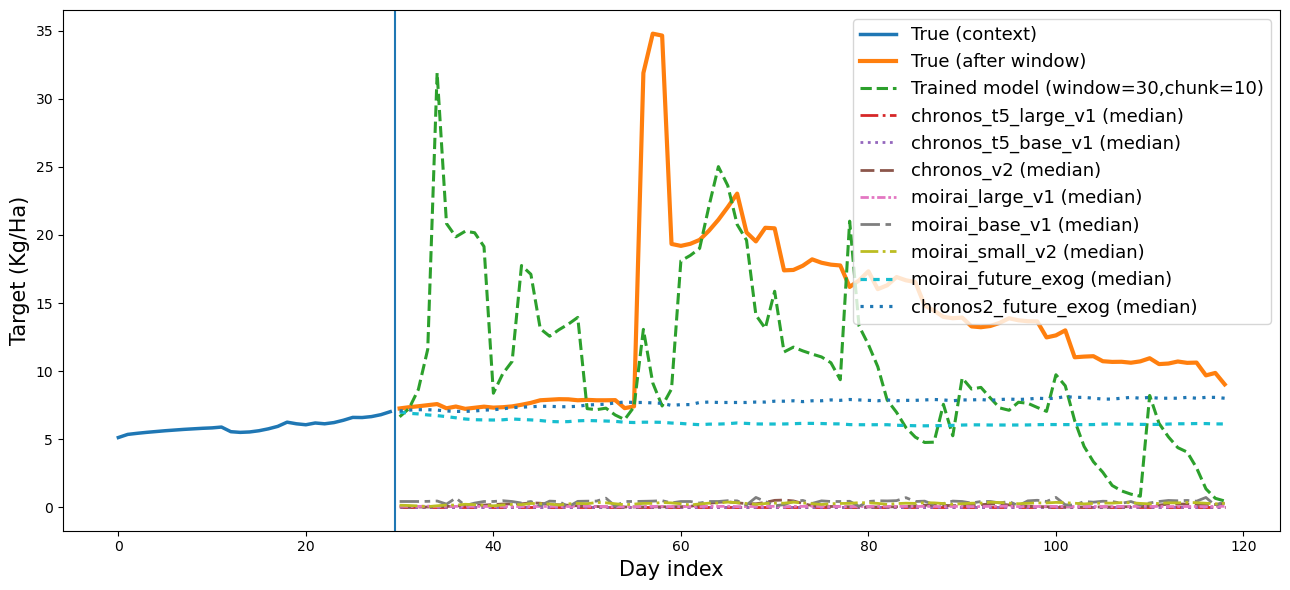

In [20]:
#This is for Soil Nitrogen Forecasting:  Trained models and Foundational Models 
#This definiton uses the 'idx' to select the time series to be forecasted. , takes results from previous defintion: this is purely a plotting defition.
#Change value of idx within 'idxs' range- to get newer Crop management scenario/Time series.
# #if you change the trained model from 'model_roll_ntotl1_w30' to 'model_roll_ntotl1_w60', please change the window also from 30 to 60 to see best results.
plot_idx_context_and_forecast(
    idx=8,
    model_roll=model_roll_ntotl1_w30,
    X_test_s=X_ntotl1,
    y_test_s=y_ntotl1,
    y_scaler=y_scaler_ntotl1,
    foundation_results=foundation_results,
    window=30,
    chunk=10,

    moirai_module_for_oracle=loaded_models["moirai_small_v2"],
    chronos2_pipeline_for_oracle=loaded_models["chronos_v2"],
    x_scaler=x_scaler_l,
    covariate_names=["NApp", "Rain", "SolarRad", "AirTempC"],
)
